# Company data project



## Loading data

Loading the data takes 1 minute. There are 4956374 companies in total. There are 4955628 companies with unique name. 63307 companies have no address (no postcode). 



In [ ]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
start = time.process_time()
data=pd.read_csv('data.csv')
print(time.process_time() - start)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


67.009731296


Alternatively, we can load the post-processed dataset (includes the latitude-longitude mapping and the distance to London)

In [ ]:
start = time.process_time()
data=pd.read_csv('UK_postcode')
print(time.process_time() - start)

We can also split between Scottish and English companies. 

In [ ]:
regex = r'SC'
SC=data[data[' CompanyNumber'].str.contains(regex, case=False, na=False)]
regex = r'[0-9]{8}'
EN=data[data[' CompanyNumber'].str.contains(regex, case=False, na=False)]

## Column analysis


### Company type
Some categories have unique letter prefixes to their company numbers, with then 6 numbers  (e.g. OC111111 is a Limited Liability Partnership, a special type of company). For our purposes, each of English and Scottish companies can be “public” or “private”. Column name is "CompanyCategory"

In [ ]:
temp=data.groupby(['CompanyCategory']).agg(['count'])['CompanyName']
temp['UK (percentage)']=100*temp/len(data)
temp=temp.rename(columns={"count": 'UK (abs)'})
temp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,UK (abs),UK (percentage)
CompanyCategory,,
Charitable Incorporated Organisation,25044,0.505289
Community Interest Company,24642,0.497178
Converted/Closed,1,0.000020
Further Education and Sixth Form College Corps,2,0.000040
Industrial and Provident Society,183,0.003692
Investment Company with Variable Capital,624,0.012590
Investment Company with Variable Capital (Securities),10,0.000202
Investment Company with Variable Capital(Umbrella),74,0.001493
Limited Liability Partnership,52713,1.063540


In [ ]:
temp=SC.groupby(['CompanyCategory']).agg(['count'])['CompanyName']
temp['SC (percentage)']=100*temp/len(SC)
temp['EN (abs)']=EN.groupby(['CompanyCategory']).agg(['count'])['CompanyName']['count']
temp['EN (percentage)']=100*temp['EN (abs)']/len(EN)
temp=temp.rename(columns={"count": 'SC (abs)'})
temp

,SC (abs),SC (percentage),EN (abs),EN (percentage)
CompanyCategory,,,,
Community Interest Company,1369,0.570728,22841.0,0.509853
Converted/Closed,1,0.000417,NaN,NaN
Old Public Company,1,0.000417,25.0,0.000558
Other Company Type,2,0.000834,2.0,0.000045
"PRI/LBG/NSC (Private, Limited by guarantee, no share capital, use of 'Limited' exemption)",3460,1.442454,35937.0,0.802180
"PRI/LTD BY GUAR/NSC (Private, limited by guarantee, no share capital)",3542,1.476639,101794.0,2.272230
"PRIV LTD SECT. 30 (Private limited company, section 30 of the Companies Act)",1,0.000417,16.0,0.000357
Private Limited Company,230978,96.293393,4309695.0,96.200331
Private Unlimited,2,0.000834,117.0,0.002612


We can now apply the mapping from company categories to public/private. 

In [ ]:
data=data[data['CompanyCategory'].isin(['Old Public Company', 'Private Limited Company', 'Public Limited Company'])]
data['CompanyCategory'] = np.where(data['CompanyCategory']  == 'Public Limited Company', 'public', data['CompanyCategory'])
data['CompanyCategory'] = np.where(data['CompanyCategory']  == 'Private Limited Company', 'private', data['CompanyCategory'])
data['CompanyCategory'] = np.where(data['CompanyCategory']  == 'Old Public Company', 'public', data['CompanyCategory'])

In [ ]:
temp=data.groupby(['CompanyCategory']).agg(['count'])['CompanyName']
temp['UK (percentage)']=100*temp/len(data)
temp=temp.rename(columns={"count": 'UK (abs)'})
print(temp)

                 UK (abs)  UK (percentage)
CompanyCategory                           
private           4608200        99.866893
public               6142         0.133107


There are other visualizations we can create once we load the datafile that includes the distance to London. 

In [ ]:

AUX=post_EN[post_EN['CompanyCategory']=='private'].groupby(['dist'])['CompanyName'].agg(['count'])
AUX['public']=post_EN[post_EN['CompanyCategory']=='public'].groupby(['dist'])['CompanyName'].agg(['count'])
AUX=AUX.rename(columns={"count": 'private'})
AUX['ratio']=AUX['public']/AUX['private']
AUX

,private,public,ratio
dist,,,
0-20,690166,1671,0.002421
100-120,120457,102,0.000847
120-200,260936,309,0.001184
20-40,147102,145,0.000986
200-300,38606,33,0.000855
40-60,112923,75,0.000664
60-80,60520,27,0.000446
80-100,68438,30,0.000438


### Distance analysis

In [ ]:
temp=data[data['CompanyCategory']=='private'].groupby(['dist'])['Mortgages.NumMortCharges'].agg(['sum'])
temp['private_count']=data[data['CompanyCategory']=='private'].groupby(['dist'])['CompanyName'].agg(['count'])
temp['public']=data[data['CompanyCategory']=='public'].groupby(['dist'])['Mortgages.NumMortCharges'].agg(['sum'])
temp['public_count']=data[data['CompanyCategory']=='public'].groupby(['dist'])['CompanyName'].agg(['count'])
temp=temp.rename(columns={"sum": 'private'})
temp['private_rate']=temp['private']/temp['private_count']
temp['public_rate']=temp['public']/temp['public_count']
temp=temp.drop(['private_count', 'public_count'], axis=1)
temp

In [ ]:
temp=data[data['Accounts.AccountCategory']=='smallest'].groupby(['dist'])['Mortgages.NumMortCharges'].agg(['sum'])
temp['smallest_count']=data[data['Accounts.AccountCategory']=='smallest'].groupby(['dist'])['CompanyName'].agg(['count'])

temp['medium']=data[data['Accounts.AccountCategory']=='medium'].groupby(['dist'])['Mortgages.NumMortCharges'].agg(['sum'])
temp['medium_count']=data[data['Accounts.AccountCategory']=='medium'].groupby(['dist'])['CompanyName'].agg(['count'])

temp['full']=data[data['Accounts.AccountCategory']=='full'].groupby(['dist'])['Mortgages.NumMortCharges'].agg(['sum'])
temp['full_count']=data[data['Accounts.AccountCategory']=='full'].groupby(['dist'])['CompanyName'].agg(['count'])

temp['subsidiary']=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['dist'])['Mortgages.NumMortCharges'].agg(['sum'])
temp['subsidiary_count']=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['dist'])['CompanyName'].agg(['count'])

temp['no_detail']=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['dist'])['Mortgages.NumMortCharges'].agg(['sum'])
temp['no_detail_count']=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['dist'])['CompanyName'].agg(['count'])

temp=temp.rename(columns={"sum": 'smallest'})
temp['no_detail_rate']=temp['no_detail']/temp['no_detail_count']
temp['smallest_rate']=temp['smallest']/temp['smallest_count']
temp['full_rate']=temp['full']/temp['full_count']
temp['medium_rate']=temp['medium']/temp['medium_count']
temp['subsidiary_rate']=temp['subsidiary']/temp['subsidiary_count']
temp=temp.drop(['smallest_count', 'no_detail_count', 'subsidiary_count', 'medium_count', 'full_count'], axis=1)
temp

In [ ]:
temp=data[data['CompanyCategory']=='private'].groupby(['dist'])['live'].agg(['sum'])
temp['private_count']=data[data['CompanyCategory']=='private'].groupby(['dist'])['CompanyName'].agg(['count'])
temp['public']=data[data['CompanyCategory']=='public'].groupby(['dist'])['live'].agg(['sum'])
temp['public_count']=data[data['CompanyCategory']=='public'].groupby(['dist'])['CompanyName'].agg(['count'])
temp=temp.rename(columns={"sum": 'private'})
temp['private_rate']=temp['private']/temp['private_count']
temp['public_rate']=temp['public']/temp['public_count']
temp=temp.drop(['private_count', 'public_count'], axis=1)
temp

In [ ]:
temp=data[data['Accounts.AccountCategory']=='smallest'].groupby(['dist'])['live'].agg(['sum'])
temp['smallest_count']=data[data['Accounts.AccountCategory']=='smallest'].groupby(['dist'])['CompanyName'].agg(['count'])

temp['medium']=data[data['Accounts.AccountCategory']=='medium'].groupby(['dist'])['live'].agg(['sum'])
temp['medium_count']=data[data['Accounts.AccountCategory']=='medium'].groupby(['dist'])['CompanyName'].agg(['count'])

temp['full']=data[data['Accounts.AccountCategory']=='full'].groupby(['dist'])['live'].agg(['sum'])
temp['full_count']=data[data['Accounts.AccountCategory']=='full'].groupby(['dist'])['CompanyName'].agg(['count'])

temp['subsidiary']=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['dist'])['live'].agg(['sum'])
temp['subsidiary_count']=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['dist'])['CompanyName'].agg(['count'])

temp['no_detail']=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['dist'])['live'].agg(['sum'])
temp['no_detail_count']=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['dist'])['CompanyName'].agg(['count'])

temp=temp.rename(columns={"sum": 'smallest'})
temp['no_detail_rate']=temp['no_detail']/temp['no_detail_count']
temp['smallest_rate']=temp['smallest']/temp['smallest_count']
temp['full_rate']=temp['full']/temp['full_count']
temp['medium_rate']=temp['medium']/temp['medium_count']
temp['subsidiary_rate']=temp['subsidiary']/temp['subsidiary_count']
temp=temp.drop(['smallest_count', 'no_detail_count', 'subsidiary_count', 'medium_count', 'full_count'], axis=1)
temp

In [ ]:
temp=data[data['CompanyCategory']=='private'].groupby(['dist']).agg(['sum'])['Mortgages.NumMortCharges']
temp['public']=data[data['CompanyCategory']=='public'].groupby(['dist']).agg(['sum'])['Mortgages.NumMortCharges']
temp=temp.rename(columns={"count": 'private'})
temp

In [ ]:
data[data['CompanyCategory']=='private'].groupby(['dist']).agg(['sum'])

### Account type
Column T tells us the type of accounts that the company will have to file. It is relevant here to note the number of NANs (empty rows). Column name is "Accounts.AccountCategory". For Scotland there is missing information for 68517 companies (28.5%).
For England there is missing information for 1304672 companies (29.1%)

In [ ]:
T=data.groupby(['Accounts.AccountCategory']).agg(['count'])['CompanyName']
T['Account type (percentage)']=100*T/len(data)
T=T.rename(columns={"count": 'Account type (abs)'})
T

,Account type (abs),Account type (percentage)
Accounts.AccountCategory,,
ACCOUNTS TYPE NOT AVAILABLE,3677,0.079686
AUDIT EXEMPTION SUBSIDIARY,12759,0.276507
AUDITED ABRIDGED,1453,0.031489
DORMANT,538506,11.670266
FILING EXEMPTION SUBSIDIARY,300,0.006501
FULL,81447,1.765084
GROUP,20057,0.434667
INITIAL,7,0.000152
MEDIUM,341,0.007390


In [ ]:
T=SC.groupby(['Accounts.AccountCategory']).agg(['count'])['CompanyName']
T['SC (percentage)']=100*T/len(SC)
T['EN (abs)']=EN.groupby(['Accounts.AccountCategory']).agg(['count'])['CompanyName']['count']
T['EN (percentage)']=100*T['EN (abs)']/len(EN)
T=T.rename(columns={"count": 'SC (abs)'})
T

,SC (abs),SC (percentage),EN (abs),EN (percentage)
Accounts.AccountCategory,,,,
ACCOUNTS TYPE NOT AVAILABLE,283,0.117981,3566,0.079600
AUDIT EXEMPTION SUBSIDIARY,549,0.228875,12229,0.272974
AUDITED ABRIDGED,54,0.022512,1283,0.028639
DORMANT,25380,10.580775,535871,11.961628
FILING EXEMPTION SUBSIDIARY,23,0.009589,285,0.006362
FULL,4380,1.825997,82431,1.840012
GROUP,1252,0.521952,21270,0.474786
MEDIUM,23,0.009589,292,0.006518
NO ACCOUNTS FILED,60027,25.024909,1226294,27.373141


We map account categories to our own categories.

In [ ]:
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Audited Abridged'.upper(), 'smallest', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Dormant'.upper(), 'smallest', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Partial Exemption'.upper(), 'smallest', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Small'.upper(), 'smallest', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Total Exemption Full'.upper(), 'smallest', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Total Exemption Small'.upper(), 'smallest', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Unaudited Abridged'.upper(), 'smallest', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Filing Exemption Subsidiary'.upper(), 'subsidiary', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Audit Exemption Subsidiary'.upper(), 'subsidiary', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Medium'.upper(), 'medium', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'No Accounts Filed'.upper(), 'no detail available', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Accounts Type Not Available'.upper(), 'no detail available', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory'].isna(), 'no detail available', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory'] == 'INITIAL', 'no detail available', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Full'.upper(), 'full', data['Accounts.AccountCategory'])
data['Accounts.AccountCategory'] = np.where(data['Accounts.AccountCategory']  == 'Group'.upper(), 'full', data['Accounts.AccountCategory'])

### Number of mortgages
Columns W-Z tells us the number of mortgages that have been registered. A supplementary aim is to correlate this to all preceding variables – is this consistent across English & Scottish companies, public & private companies, and account types? Or does it vary?

Mortgages.NumMortCharges	Mortgages.NumMortOutstanding	Mortgages.NumMortPartSatisfied	Mortgages.NumMortSatisfied

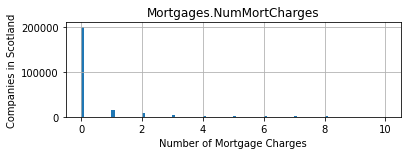

In [ ]:
aux=pd.DataFrame(SC['Mortgages.NumMortCharges'])
axarr=aux.hist(bins=100, range=(0, 10), sharex=True, sharey=True, layout = (2, 1))
for ax in axarr.flatten():
    ax.set_xlabel("Number of Mortgage Charges")
    ax.set_ylabel("Companies in Scotland")

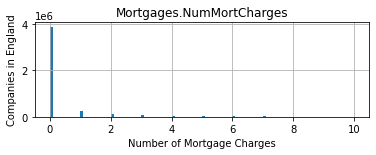

In [ ]:
aux=pd.DataFrame(EN['Mortgages.NumMortCharges'])
axarr=aux.hist(bins=100, range=(0, 10), sharex=True, sharey=True, layout = (2, 1))
for ax in axarr.flatten():
    ax.set_xlabel("Number of Mortgage Charges")
    ax.set_ylabel("Companies in England")

Let´s now obtain the tables of the number of mortgages for each company in the different account type.

In [ ]:
MORT=data.groupby(['Accounts.AccountCategory'])['Mortgages.NumMortCharges'].agg(['sum'])
MORT['Per company (UK)']=data.groupby(['Accounts.AccountCategory'])[' CompanyNumber'].agg('count')
MORT['Per company (UK)']=MORT['sum']/MORT['Per company (UK)']
MORT=MORT.rename(columns={"sum": 'Total (UK)'})
MORT

,Total (UK),Per company (UK)
Accounts.AccountCategory,,
full,643166,6.336361
medium,3231,9.475073
no detail available,454462,0.173231
smallest,1667052,0.888622
subsidiary,40652,3.112949


In [ ]:
MORT=SC.groupby(['CompanyCategory'])['Mortgages.NumMortCharges'].agg(['sum'])
MORT['Per company (SC)']=SC.groupby(['CompanyCategory'])[' CompanyNumber'].agg('count')
MORT['Per company (SC)']=MORT['sum']/MORT['Per company (SC)']
MORT['Total (EN)']=EN.groupby(['CompanyCategory'])['Mortgages.NumMortCharges'].agg(['sum'])
MORT['Per company (EN)']=EN.groupby(['CompanyCategory'])[' CompanyNumber'].agg('count')
MORT['Per company (EN)']=MORT['Total (EN)']/MORT['Per company (EN)']
MORT=MORT.rename(columns={"sum": 'Total (SC)'})
MORT

,Total (SC),Per company (SC),Total (EN),Per company (EN)
CompanyCategory,,,,
private,159284,0.689607,2559152,0.593813
public,1733,8.252381,34546,5.849306


We have been visualizing the number of mortgage charges. Let's now see the live mortgages. 

In [ ]:
data['live mortgages']=data['Mortgages.NumMortOutstanding']+data['Mortgages.NumMortPartSatisfied']

In [ ]:
MORT=data.groupby(['CompanyCategory'])['live mortgages'].agg(['sum'])
MORT['Per company (UK)']=data.groupby(['CompanyCategory'])[' CompanyNumber'].agg('count')
MORT['Per company (UK)']=MORT['sum']/MORT['Per company (UK)']
MORT=MORT.rename(columns={"sum": 'Total (UK)'})
MORT

,Total (UK),Per company (UK)
CompanyCategory,,
private,1539662,0.334114
public,13951,2.271410


In [ ]:
MORT=data.groupby(['Accounts.AccountCategory'])['live mortgages'].agg(['sum'])
MORT['Per company (UK)']=data.groupby(['Accounts.AccountCategory'])[' CompanyNumber'].agg('count')
MORT['Per company (UK)']=MORT['sum']/MORT['Per company (UK)']
MORT=MORT.rename(columns={"sum": 'Total (UK)'})
MORT

,Total (UK),Per company (UK)
Accounts.AccountCategory,,
full,302384,2.979035
medium,1903,5.580645
no detail available,315706,0.120340
smallest,922855,0.491928
subsidiary,10765,0.824336


### Company status
Column L tells us the company status – is it active or in the process of being liquidated. Once more, reviewing this across all variables will be helpful. Name of the column is "CompanyStatus".

In [ ]:
L=SC.groupby(['CompanyStatus']).agg(['count'])['CompanyName']
L['SC (percentage)']=100*L/len(SC)
L['EN (abs)']=EN.groupby(['CompanyStatus']).agg(['count'])['CompanyName']['count']
L['EN (percentage)']=100*L['EN (abs)']/len(EN)
L=L.rename(columns={"count": 'SC (abs)'})
L

,SC (abs),SC (percentage),EN (abs),EN (percentage)
CompanyStatus,,,,
ADMINISTRATION ORDER,6,0.002501,123.0,0.002746
Active,222757,92.866106,4203927.0,93.839395
Active - Proposal to Strike off,11904,4.962709,182428.0,4.072129
In Administration,200,0.083379,2493.0,0.055648
In Administration/Administrative Receiver,17,0.007087,305.0,0.006808
Liquidation,4779,1.992337,88650.0,1.978831
RECEIVERSHIP,192,0.080044,NaN,NaN
Voluntary Arrangement,14,0.005837,748.0,0.016697


# Temporal plots

In this section we are going to see when active companies were created, dividing these by features.

In [ ]:
dic={1: "0-50", 2:"50-100", 3:"100-150", 4:"150-200", 5:"200-250", 6:"250-300", 7:"300-350", 8:"350-400", 9:"400-450", 10:"450-500", 11:">500"}

([<matplotlib.axis.XTick at 0x7eff20011590>,
 <a list of 10 Text major ticklabel objects>)

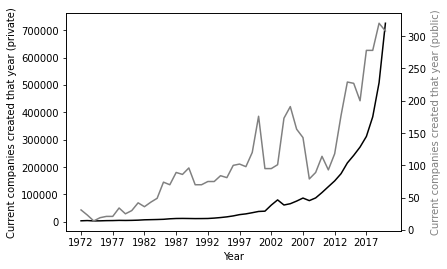

In [ ]:
AUX=data[data['CompanyCategory']=='private'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
private=np.array(AUX.groupby(level=0).sum()['count'])

AUX=data[data['CompanyCategory']=='public'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
public=np.array(AUX.groupby(level=0).sum()['count'])

#private=moving_average(private, 7)
#public=moving_average(public, 7)

#fig, ax1 = plt.plot()#subplots()
fig,ax1 = plt.subplots()#figure()
ax2 = ax1.twinx()
ax1.plot(years_1[-50:-1], private[-50:-1], 'k-')
ax2.plot(years_2[-50:-1], public[-50:-1], 'gray')


ax1.set_xlabel('Year')
ax1.set_ylabel('Current companies created that year (private)', color='black')
ax2.set_ylabel('Current companies created that year (public)', color='gray')
plt.xticks(np.arange(0, 49, step=5)) 

In [ ]:
AUX=data[data['CompanyCategory']=='private' & data['dist']=='0-50'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
private_1=np.array(AUX.groupby(level=0).sum()['count'])

AUX=data[data['CompanyCategory']=='private' & data['dist']=='50-100'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
private_2=np.array(AUX.groupby(level=0).sum()['count'])



In [ ]:
plot_priv={}

for idx in range(11):
  idx=idx+1
  AUX=data[(data['CompanyCategory']=='private') & (data['dist']==dic[idx])].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
  new_idx=[]
  for i in AUX.index:
    new_idx.append(i[-4:])
  new_idx
  AUX=AUX.set_axis(new_idx)
  AUX=AUX.sort_index()
  plot_priv["years_"+str(idx)]=np.array(AUX.groupby(level=0).sum().index) #.plot()
  plot_priv["private_"+str(idx)]=np.array(AUX.groupby(level=0).sum()['count'])

In [ ]:
plot_pub={}

for idx in range(11):
  idx=idx+1
  AUX=data[(data['CompanyCategory']=='public') & (data['dist']==dic[idx])].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
  new_idx=[]
  for i in AUX.index:
    new_idx.append(i[-4:])
  new_idx
  AUX=AUX.set_axis(new_idx)
  AUX=AUX.sort_index()
  plot_pub["years_"+str(idx)]=np.array(AUX.groupby(level=0).sum().index) #.plot()
  plot_pub["pub_"+str(idx)]=np.array(AUX.groupby(level=0).sum()['count'])

In [ ]:
fig,ax1 = plt.subplots()#figure()
ax2 = ax1.twinx()

for idx in range(11):
  idx=idx+1
  ax1.plot(plot_priv["years_"+str(idx)][-50:-1], plot_priv["private_"+str(idx)][-50:-1], label=dic[idx])
  #ax2.plot(plot_pub["years_"+str(idx)][-20:-1], plot_pub["pub_"+str(idx)][-20:-1], label=str(idx))


ax1.set_xlabel('Year')
ax1.set_ylabel('Current companies created that year (private)', color='black')
ax2.set_ylabel('Current companies created that year (public)', color='gray')
fig.legend()
plt.xticks(np.arange(0, 49, step=5)) 

In [ ]:
AUX=data[data['CompanyCategory']=='private'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
private2=np.array(AUX.groupby(level=0).sum()['count'])

AUX=data[data['CompanyCategory']=='public'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
public2=np.array(AUX.groupby(level=0).sum()['count'])

In [ ]:
fig,ax1 = plt.subplots()#figure()
ax2 = ax1.twinx()
ax1.plot(years_1[-50:-1], private[-50:-1]/private2[-50:-1], 'k-')
ax2.plot(years_2[-50:-1], public[-50:-1]/public2[-50:-1], 'gray')


ax1.set_xlabel('Year the company was founded')
ax1.set_ylabel('Mortgages filled by current companies (private)', color='black')
ax2.set_ylabel('Mortgages filled by current companies (public)', color='gray')
plt.xticks(np.arange(0, 49, step=5)) 

In [ ]:
AUX=data[data['CompanyCategory']=='private'].groupby(['IncorporationDate']).agg(['sum'])['live']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
private=np.array(AUX.groupby(level=0).sum()['sum'])

AUX=data[data['CompanyCategory']=='private'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
private2=np.array(AUX.groupby(level=0).sum()['count'])



AUX=data[data['CompanyCategory']=='public'].groupby(['IncorporationDate']).agg(['sum'])['live']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
public=np.array(AUX.groupby(level=0).sum()['sum'])

AUX=data[data['CompanyCategory']=='public'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
public2=np.array(AUX.groupby(level=0).sum()['count'])

In [ ]:
#fig, ax1 = plt.plot()#subplots()
fig,ax1 = plt.subplots()#figure()
ax2 = ax1.twinx()
ax1.plot(years_1[-50:-1], private[-50:-1]/private2[-50:-1], 'k-')
ax2.plot(years_2[-50:-1], public[-50:-1]/public2[-50:-1], 'gray')


ax1.set_xlabel('Year the company was founded')
ax1.set_ylabel('Live mortgages filled by current companies (private)', color='black')
ax2.set_ylabel('Live mortgages filled by current companies (public)', color='gray')
plt.xticks(np.arange(0, 49, step=5)) 

In [ ]:
AUX.groupby(level=0).sum()[120:].plot()
plt.xlabel("Year")
plt.ylabel("Number of NEW companies in Scotland")

In [ ]:
AUX=EN.groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
AUX.groupby(level=0).sum().cumsum().plot()
plt.xlabel("Year")
plt.ylabel("Number of companies in England")

In [ ]:
AUX.groupby(level=0).sum()[120:].plot()
plt.xlabel("Year")
plt.ylabel("Number of NEW companies in England")

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

([<matplotlib.axis.XTick at 0x7f80531cca10>,
 <a list of 6 Text major ticklabel objects>)

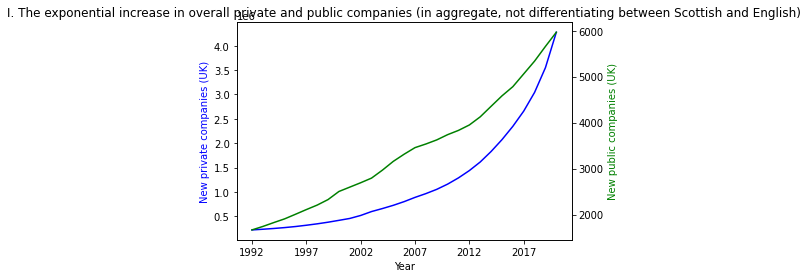

In [ ]:
AUX=data[data['CompanyCategory']=='private'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
private=np.array(AUX.groupby(level=0).sum()['count'].cumsum())

AUX=data[data['CompanyCategory']=='public'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
public=np.array(AUX.groupby(level=0).sum()['count'].cumsum())

#private=moving_average(private, 7)
#public=moving_average(public, 7)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(years_1[-30:-1], private[-30:-1], 'b-')
ax2.plot(years_2[-30:-1], public[-30:-1], 'g-')
plt.title('I. The exponential increase in overall private and public companies (in aggregate, not differentiating between Scottish and English)')
ax1.set_xlabel('Year')
ax1.set_ylabel('New private companies (UK)', color='b')
ax2.set_ylabel('New public companies (UK)', color='g')
plt.xticks(np.arange(0, 29, step=5))


In [ ]:
AUX=data[data['Accounts.AccountCategory']=='smallest'].groupby(['IncorporationDate']).agg(['sum'])['Mortgages.NumMortCharges']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
smallest=np.array(AUX.groupby(level=0).sum()['sum'])

AUX=data[data['Accounts.AccountCategory']=='full'].groupby(['IncorporationDate']).agg(['sum'])['Mortgages.NumMortCharges']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
full=np.array(AUX.groupby(level=0).sum()['sum'])
#private=moving_average(private, 7)
#public=moving_average(public, 7)

AUX=data[data['Accounts.AccountCategory']=='medium'].groupby(['IncorporationDate']).agg(['sum'])['Mortgages.NumMortCharges']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_3=np.array(AUX.groupby(level=0).sum().index) #.plot()
medium=np.array(AUX.groupby(level=0).sum()['sum'])


AUX=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['IncorporationDate']).agg(['sum'])['Mortgages.NumMortCharges']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_4=np.array(AUX.groupby(level=0).sum().index) #.plot()
subsidiary=np.array(AUX.groupby(level=0).sum()['sum'])

AUX=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['IncorporationDate']).agg(['sum'])['Mortgages.NumMortCharges']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_5=np.array(AUX.groupby(level=0).sum().index) #.plot()
nodetail=np.array(AUX.groupby(level=0).sum()['sum'])


In [ ]:
AUX=data[data['Accounts.AccountCategory']=='medium'].groupby(['IncorporationDate']).agg(['sum'])['live mortgages']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_3=np.array(AUX.groupby(level=0).sum().index) #.plot()
medium=np.array(AUX.groupby(level=0).sum()['sum'])

In [ ]:
AUX=data[data['Accounts.AccountCategory']=='smallest'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
smallest2=np.array(AUX.groupby(level=0).sum()['count'])

AUX=data[data['Accounts.AccountCategory']=='full'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
full2=np.array(AUX.groupby(level=0).sum()['count'])
#private=moving_average(private, 7)
#public=moving_average(public, 7)

AUX=data[data['Accounts.AccountCategory']=='medium'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_3=np.array(AUX.groupby(level=0).sum().index) #.plot()
medium2=np.array(AUX.groupby(level=0).sum()['count'])


AUX=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_4=np.array(AUX.groupby(level=0).sum().index) #.plot()
subsidiary2=np.array(AUX.groupby(level=0).sum()['count'])

AUX=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_5=np.array(AUX.groupby(level=0).sum().index) #.plot()
nodetail2=np.array(AUX.groupby(level=0).sum()['count'])

([<matplotlib.axis.XTick at 0x7fc8abce3750>,
 <a list of 4 Text major ticklabel objects>)

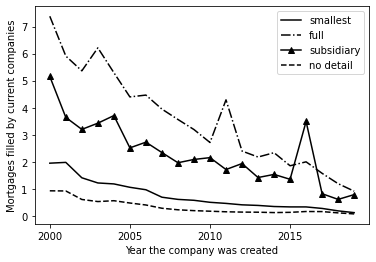

In [ ]:
aux=0
#medium=[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 0]
plt.plot(years_1[-22-aux:-2], smallest[-22-aux:-2]/smallest2[-22-aux:-2], 'k-', label='smallest')
plt.plot(years_2[-21-aux:-1], full[-21-aux:-1]/full2[-21-aux:-1], 'k-.', label='full')
#plt.plot(years_2[-21-aux:-1], medium[-20-aux:]/medium2[-20-aux:], 'k-o', label='medium')
plt.plot(years_4[-21-aux:-1], subsidiary[-21-aux:-1]/subsidiary2[-21-aux:-1], 'k-^', label='subsidiary')
plt.plot(years_5[-22-aux:-2], nodetail[-22-aux:-2]/nodetail2[-22-aux:-2], 'k--', label='no detail')

#plt.title('I. The exponential increase in overall private and public companies (in aggregate, not differentiating between Scottish and English)')
plt.xlabel('Year the company was created')
plt.ylabel('Mortgages filled by current companies')
plt.legend()
plt.xticks(np.arange(0, 19+aux, step=5))

In [ ]:
AUX=data[data['Accounts.AccountCategory']=='smallest'].groupby(['IncorporationDate']).agg(['sum'])['live']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
smallest=np.array(AUX.groupby(level=0).sum()['sum'])

AUX=data[data['Accounts.AccountCategory']=='full'].groupby(['IncorporationDate']).agg(['sum'])['live']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
full=np.array(AUX.groupby(level=0).sum()['sum'])
#private=moving_average(private, 7)
#public=moving_average(public, 7)

AUX=data[data['Accounts.AccountCategory']=='medium'].groupby(['IncorporationDate']).agg(['sum'])['live']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_3=np.array(AUX.groupby(level=0).sum().index) #.plot()
medium=np.array(AUX.groupby(level=0).sum()['sum'])


AUX=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['IncorporationDate']).agg(['sum'])['live']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_4=np.array(AUX.groupby(level=0).sum().index) #.plot()
subsidiary=np.array(AUX.groupby(level=0).sum()['sum'])

AUX=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['IncorporationDate']).agg(['sum'])['live']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_5=np.array(AUX.groupby(level=0).sum().index) #.plot()
nodetail=np.array(AUX.groupby(level=0).sum()['sum'])

In [ ]:
AUX=data[data['Accounts.AccountCategory']=='smallest'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
smallest2=np.array(AUX.groupby(level=0).sum()['count'])

AUX=data[data['Accounts.AccountCategory']=='full'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
full2=np.array(AUX.groupby(level=0).sum()['count'])
#private=moving_average(private, 7)
#public=moving_average(public, 7)

AUX=data[data['Accounts.AccountCategory']=='medium'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_3=np.array(AUX.groupby(level=0).sum().index) #.plot()
medium2=np.array(AUX.groupby(level=0).sum()['count'])


AUX=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_4=np.array(AUX.groupby(level=0).sum().index) #.plot()
subsidiary2=np.array(AUX.groupby(level=0).sum()['count'])

AUX=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_5=np.array(AUX.groupby(level=0).sum().index) #.plot()
nodetail2=np.array(AUX.groupby(level=0).sum()['count'])

medium=[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 0]
plt.plot(years_1[-22:-2], smallest[-22:-2]/smallest2[-22:-2], 'k-', label='smallest')
plt.plot(years_2[-21:-1], full[-21:-1]/full2[-21:-1], 'k-.', label='full')
plt.plot(years_2[-21:-1], medium[-20:]/medium2[-20:], 'k-o', label='medium')
plt.plot(years_4[-21:-1], subsidiary[-21:-1]/subsidiary2[-21:-1], 'k-^', label='subsidiary')
plt.plot(years_5[-22:-2], nodetail[-22:-2]/nodetail2[-22:-2], 'k--', label='no detail')

#plt.title('I. The exponential increase in overall private and public companies (in aggregate, not differentiating between Scottish and English)')
plt.xlabel('Year the company was created')
plt.ylabel('Live mortgages filled by current companies')
plt.legend()
plt.xticks(np.arange(0, 19, step=4))

([<matplotlib.axis.XTick at 0x7fb3814948d0>,
 <a list of 5 Text major ticklabel objects>)

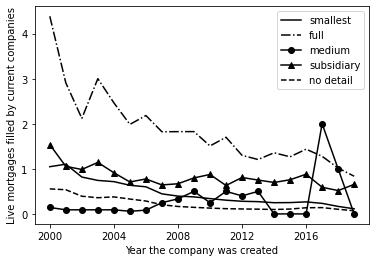

In [ ]:
medium=[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 0]
plt.plot(years_1[-22:-2], smallest[-22:-2]/smallest2[-22:-2], 'k-', label='smallest')
plt.plot(years_2[-21:-1], full[-21:-1]/full2[-21:-1], 'k-.', label='full')
plt.plot(years_2[-21:-1], medium[-20:]/medium2[-20:], 'k-o', label='medium')
plt.plot(years_4[-21:-1], subsidiary[-21:-1]/subsidiary2[-21:-1], 'k-^', label='subsidiary')
plt.plot(years_5[-22:-2], nodetail[-22:-2]/nodetail2[-22:-2], 'k--', label='no detail')

#plt.title('I. The exponential increase in overall private and public companies (in aggregate, not differentiating between Scottish and English)')
plt.xlabel('Year the company was created')
plt.ylabel('Live mortgages filled by current companies')
plt.legend()
plt.xticks(np.arange(0, 19, step=4))

([<matplotlib.axis.XTick at 0x7fa2b8627a10>,
 <a list of 5 Text major ticklabel objects>)

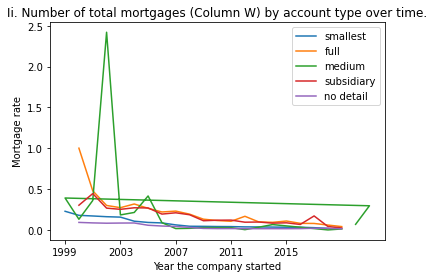

In [ ]:
AUX=data[data['Accounts.AccountCategory']=='smallest'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index) #.plot()
smallest=np.array(AUX.groupby(level=0).sum().cumsum()['count'])

AUX=data[data['Accounts.AccountCategory']=='smallest'].groupby(['IncorporationDate'])['Mortgages.NumMortCharges'].agg(['sum'])
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index)[-50:-1] #.plot()
smallest_mort=np.array(AUX.groupby(level=0).sum()['sum'])[-50:-1]/smallest[-50:-1]


AUX=data[data['Accounts.AccountCategory']=='full'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index) #.plot()
full=np.array(AUX.groupby(level=0).sum().cumsum()['count'])

AUX=data[data['Accounts.AccountCategory']=='full'].groupby(['IncorporationDate'])['Mortgages.NumMortCharges'].agg(['sum'])
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index)[-50:-1] #.plot()
full_mort=np.array(AUX.groupby(level=0).sum()['sum'])[-50:-1]/full[-50:-1]



AUX=data[data['Accounts.AccountCategory']=='medium'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_3=np.array(AUX.groupby(level=0).sum().index) #.plot()
medium=np.array(AUX.groupby(level=0).sum().cumsum()['count'])


AUX=data[data['Accounts.AccountCategory']=='medium'].groupby(['IncorporationDate'])['Mortgages.NumMortCharges'].agg(['sum'])
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index)[-50:-1] #.plot()
medium_mort=np.array(AUX.groupby(level=0).sum()['sum'])[-50:-1]/medium[-50:-1]


AUX=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_4=np.array(AUX.groupby(level=0).sum().index) #.plot()
subsidiary=np.array(AUX.groupby(level=0).sum().cumsum()['count'])

AUX=data[data['Accounts.AccountCategory']=='subsidiary'].groupby(['IncorporationDate'])['Mortgages.NumMortCharges'].agg(['sum'])
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index)[-50:-1] #.plot()
subsidiary_mort=np.array(AUX.groupby(level=0).sum()['sum'])[-50:-1]/subsidiary[-50:-1]

AUX=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_5=np.array(AUX.groupby(level=0).sum().index) #.plot()
nodetail=np.array(AUX.groupby(level=0).sum().cumsum()['count'])


AUX=data[data['Accounts.AccountCategory']=='no detail available'].groupby(['IncorporationDate'])['Mortgages.NumMortCharges'].agg(['sum'])
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index)[-50:-1] #.plot()
nodetail_mort=np.array(AUX.groupby(level=0).sum()['sum'])[-50:-1]/nodetail[-50:-1]


plt.plot(years_1[-22:-2], smallest_mort[-22:-2], label='smallest')
plt.plot(years_2[-21:-1], full_mort[-21:-1], label='full')
plt.plot(years_3[-20:], medium_mort[-20:], label='medium')
plt.plot(years_4[-21:-1], subsidiary_mort[-21:-1], label='subsidiary')
plt.plot(years_5[-22:-2], nodetail_mort[-22:-2], label='no detail')

plt.title('Ii. Number of total mortgages (Column W) by account type over time.')
plt.xlabel('Year the company started')
plt.ylabel('Mortgage rate')
plt.legend()
plt.xticks(np.arange(0, 19, step=4))

In [ ]:
AUX=data[data['CompanyCategory']=='private'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
private=np.array(AUX.groupby(level=0).sum().cumsum()['count'])

AUX=data[data['CompanyCategory']=='public'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
public=np.array(AUX.groupby(level=0).sum().cumsum()['count'])

AUX=data[data['CompanyCategory']=='private'].groupby(['IncorporationDate'])['Mortgages.NumMortCharges'].agg(['sum'])
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index)[-50:-1] #.plot()
private_mort=np.array(AUX.groupby(level=0).sum()['sum'])[-50:-1]/private[-50:-1]

AUX=data[data['CompanyCategory']=='public'].groupby(['IncorporationDate'])['Mortgages.NumMortCharges'].agg(['sum'])
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index)[-50:-1] #.plot()
public_mort=np.array(AUX.groupby(level=0).sum()['sum'])[-50:-1]/public[-50:-1]

([<matplotlib.axis.XTick at 0x7fa2bf15e490>,
 <a list of 10 Text major ticklabel objects>)

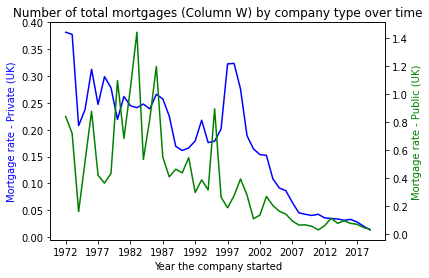

In [ ]:
AUX=data[data['CompanyCategory']=='private'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
private=np.array(AUX.groupby(level=0).sum().cumsum()['count'])

AUX=data[data['CompanyCategory']=='public'].groupby(['IncorporationDate']).agg(['count'])['CompanyName']
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
public=np.array(AUX.groupby(level=0).sum().cumsum()['count'])

AUX=data[data['CompanyCategory']=='private'].groupby(['IncorporationDate'])['Mortgages.NumMortCharges'].agg(['sum'])
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_1=np.array(AUX.groupby(level=0).sum().index)[-50:-1] #.plot()
private_mort=np.array(AUX.groupby(level=0).sum()['sum'])[-50:-1]/private[-50:-1]

AUX=data[data['CompanyCategory']=='public'].groupby(['IncorporationDate'])['Mortgages.NumMortCharges'].agg(['sum'])
new_idx=[]
for i in AUX.index:
  new_idx.append(i[-4:])
new_idx
AUX=AUX.set_axis(new_idx)
AUX=AUX.sort_index()
years_2=np.array(AUX.groupby(level=0).sum().index)[-50:-1] #.plot()
public_mort=np.array(AUX.groupby(level=0).sum()['sum'])[-50:-1]/public[-50:-1]

#private=moving_average(private, 7)
#public=moving_average(public, 7)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(years_1[-50:-1], private_mort[-50:-1], 'b-')
ax2.plot(years_2[-50:-1], public_mort[-50:-1], 'g-')


plt.title('Number of total mortgages (Column W) by company type over time')
ax1.set_xlabel('Year the company started')
ax1.set_ylabel('Mortgage rate - Private (UK)', color='b')
ax2.set_ylabel('Mortgage rate - Public (UK)', color='g')
plt.xticks(np.arange(0, 50, step=5)) 



# Miscellaneous plots

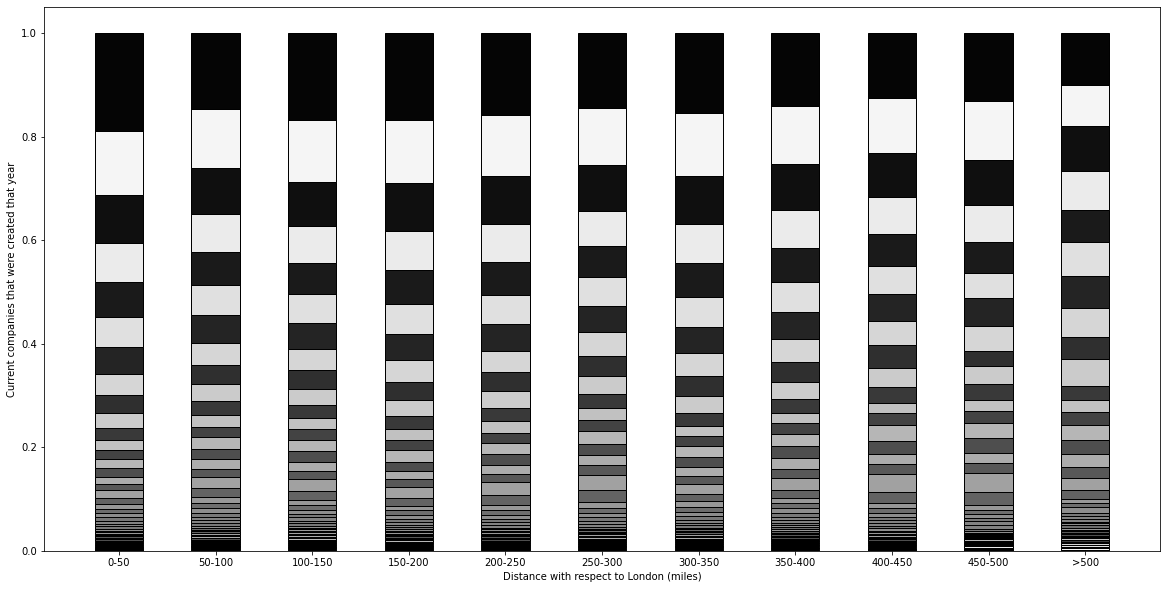

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


row_sums = aux.transpose().sum(axis=1)
new_matrix = aux.transpose()/ row_sums[:, np.newaxis]

data = new_matrix.transpose()


my_cmap = plt.get_cmap("gray")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

def rescale(i):
  if i%2==0: return 1-(i/49)
  else: return (i/49)
  


def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

#color_list = ['b', 'g', 'r']

plt.figure(figsize=(20, 10))


bar_label=dic_priv['years_1'][:11]

X = np.arange(data.shape[1])
for i in range(data.shape[0]):
  bar_plot=plt.bar(list(dic.values()), data[i],
    bottom = np.sum(data[:i], axis = 0),
    color=my_cmap(rescale(i)), edgecolor="black", width=0.5)  #my_cmap(rescale(i))
  #autolabel(bar_plot)



plt.xlabel('Distance with respect to London (miles)')
plt.ylabel('Current companies that were created that year')
#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=my_cmap), orientation='vertical')
plt.show()